# Handling Categorical Features

While we did handle the cleaning process earlier on, just for the sake of using more of what scikit-learn has to offer, using the column transformers within `src/data_pipelines.py` I'm going to create a pipeline which can be used for encoding to get an idea of the categorical data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

pd.set_option("mode.copy_on_write", True)

In [2]:
# Using the raw datasets to perform cleaning using pipeline(s)

train = pd.read_csv("../data/raw/train.csv", index_col="Id")
test = pd.read_csv("../data/raw/test.csv", index_col="Id")

In [3]:
SalePrice = train["SalePrice"]
train = train.drop(columns=["SalePrice"])

In [4]:
from src.data_pipelines import preprocessing

training = preprocessing.fit_transform(train)
testing = preprocessing.transform(test)

In [5]:
feature_names = preprocessing.get_feature_names_out()

train_df = pd.DataFrame(training, columns=feature_names, index=train.index)
test_df = pd.DataFrame(testing, columns=feature_names, index=test.index)

train_df["SalePrice"] = SalePrice

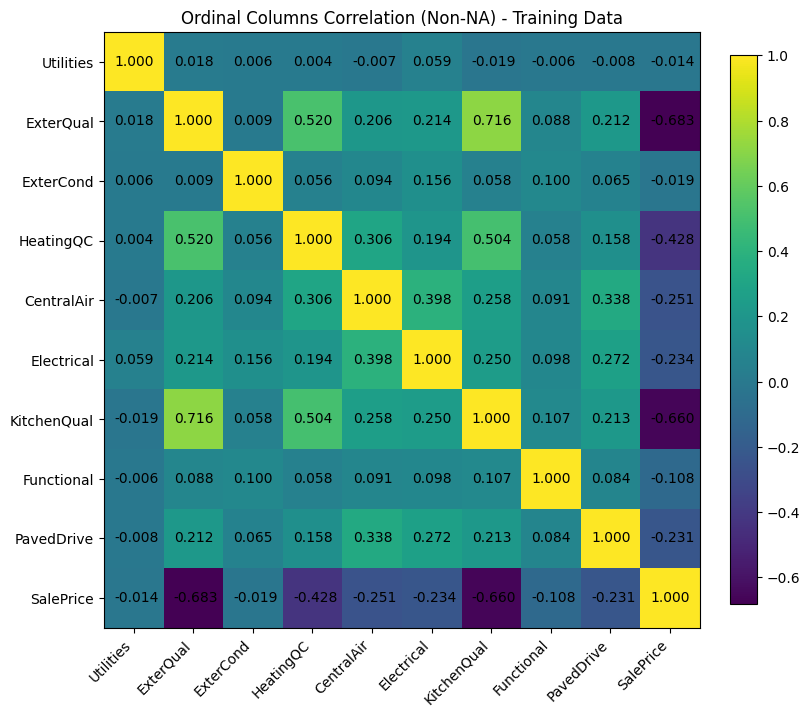

In [6]:
ord_cols = ["Utilities", "ExterQual", "ExterCond", "HeatingQC", "CentralAir", "Electrical", "KitchenQual", "Functional", "PavedDrive", "SalePrice"]
corr = train_df[["ord_cols__Utilities", "ord_cols__ExterQual", "ord_cols__ExterCond", "ord_cols__HeatingQC", "ord_cols__CentralAir", "ord_cols__Electrical", "ord_cols__KitchenQual", "ord_cols__Functional", "ord_cols__PavedDrive", "SalePrice"]].corr().to_numpy()


plt.subplots(figsize=(8,8), layout="constrained")
plt.imshow(corr)
plt.title("Ordinal Columns Correlation (Non-NA) - Training Data")
plt.yticks(ticks=range(len(ord_cols)), labels=[col for col in ord_cols])
plt.xticks(ticks=range(len(ord_cols)), labels=[col for col in ord_cols], rotation=45, ha="right", va='top')
plt.colorbar(shrink=.70)

for x in range(len(corr)):
    for y in range(len(corr[x])):
        plt.annotate(text=f"{corr[x,y]:.3f}", xy=(x-.325,y+0.0575))

plt.show()

There are some values here that might provide some value when enigneering new features. Notably KitchenQual is has a strong correalation with ExterQual and to a lesser extent, also HeatingQC. It's hard to determine how accurate this might actually be however since in order to provide this numerical representation encoding of these values was required. Engineering these features might negatively affect the model more than expected but we can observe this later on.

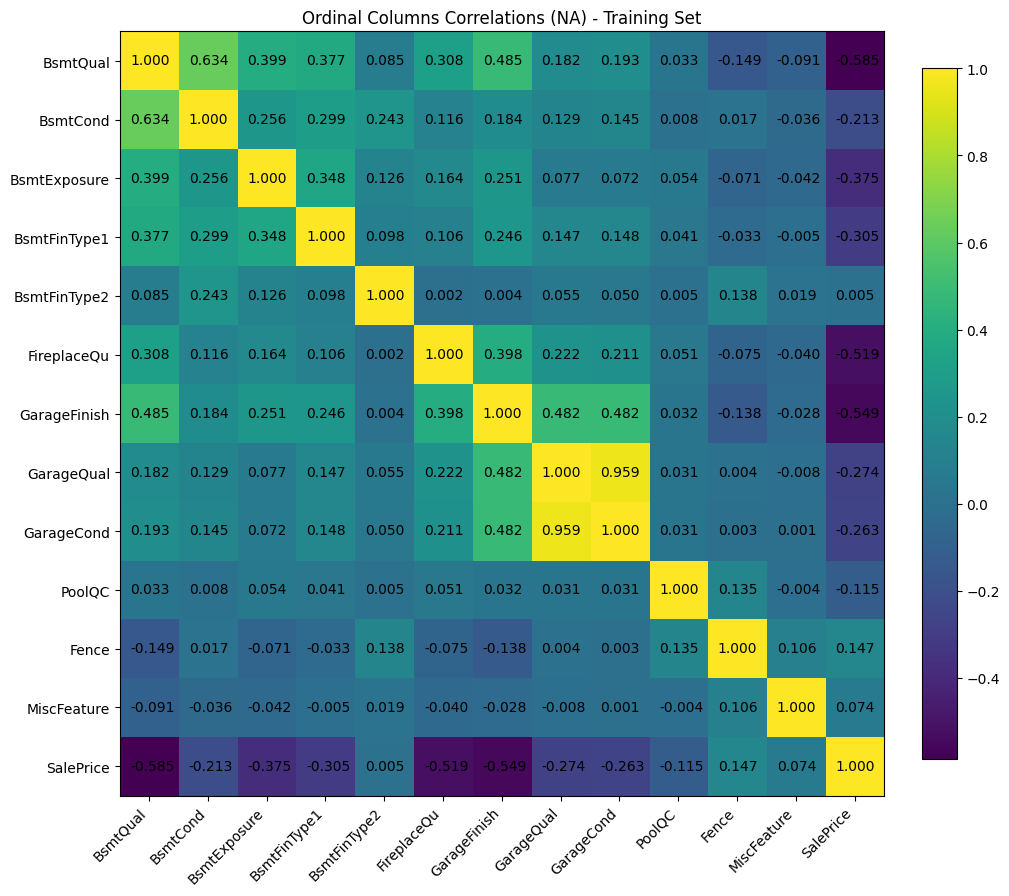

In [7]:
na_ord_cols = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature", "SalePrice"]

corr = train_df[["na_ord_cols__BsmtQual", "na_ord_cols__BsmtCond", "na_ord_cols__BsmtExposure", "na_ord_cols__BsmtFinType1", "na_ord_cols__BsmtFinType2", "na_ord_cols__FireplaceQu", "na_ord_cols__GarageFinish", "na_ord_cols__GarageQual", "na_ord_cols__GarageCond", "na_ord_cols__PoolQC", "na_ord_cols__Fence", "na_ord_cols__MiscFeature", "SalePrice"]].corr().to_numpy()

plt.subplots(figsize=(10,10), layout="constrained")
plt.imshow(corr)
plt.title("Ordinal Columns Correlations (NA) - Training Set")
plt.yticks(ticks=range(len(na_ord_cols)), labels=[col for col in na_ord_cols])
plt.xticks(ticks=range(len(na_ord_cols)), labels=[col for col in na_ord_cols], rotation=45, ha="right", va='top')
plt.colorbar(shrink=.70)

for x in range(len(corr)):
    for y in range(len(corr[x])):
        plt.annotate(text=f"{corr[x,y]:.3f}", xy=(x-.325,y+0.0575))

plt.show()

Similarly to the previous plot, there are notable features which have strong correlation with one another. BsmtQual & BsmtCond along with GarageQual & GarageCond seem to have the most promising correlations. Also GarageFinish seems to have a correlation with GarageQual & GarageCond. I suppose that the assumptions from the previous section were correct. While creating this plot wasn't entirely required, this does give a visual idea of what might be going on.

Now using the feature engineering pipeline, let's see if there are any correlations using the engineered features.

In [8]:
from sklearn.pipeline import make_pipeline
from src.data_pipelines import feature_eng

pipeline = make_pipeline(
    preprocessing.set_output(transform="pandas"),
    feature_eng
)

In [9]:
training = pipeline.fit_transform(train)

In [12]:
train_df = pd.DataFrame(training, columns=pipeline.get_feature_names_out(), index=train.index)
train_df["SalePrice"] = SalePrice

Now that the new pipeline has been fit/transformed let's use the new features to see if there's any correlation.

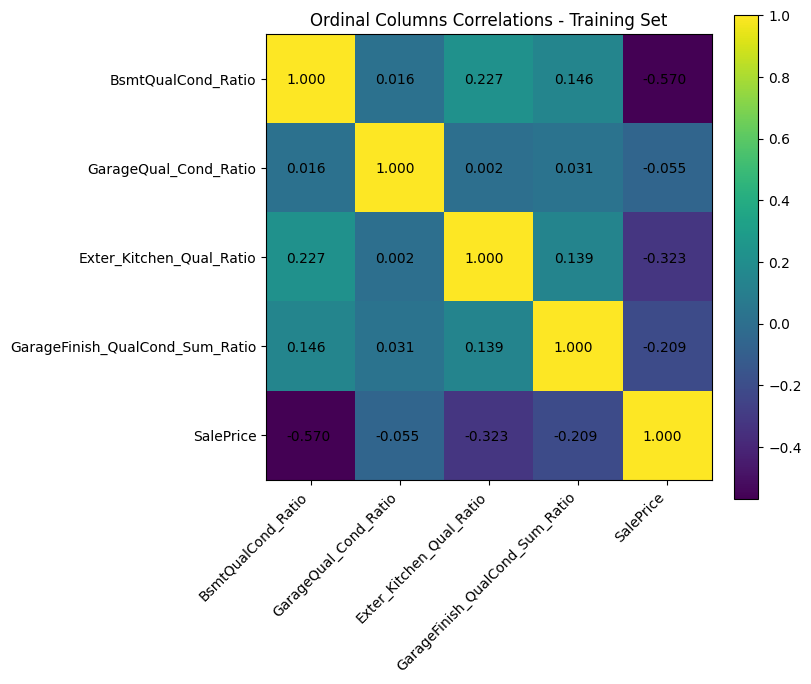

In [16]:
na_ord_cols = ["BsmtQualCond_Ratio", "GarageQual_Cond_Ratio", "Exter_Kitchen_Qual_Ratio", "GarageFinish_QualCond_Sum_Ratio", "SalePrice"]
corr = train_df[['BmstQual_Cond__ratio', 'GarageQual_Cond__ratio', 'Exter_Kitchen_Qual__ratio', 'GarageFinish_Qual_Cond__sum_ratio', 'SalePrice']].corr().to_numpy()


plt.subplots(figsize=(8,8), layout="constrained")
plt.imshow(corr)
plt.title("Ordinal Columns Correlations - Training Set")
plt.yticks(ticks=range(len(na_ord_cols)), labels=[col for col in na_ord_cols])
plt.xticks(ticks=range(len(na_ord_cols)), labels=[col for col in na_ord_cols], rotation=45, ha="right", va='top')
plt.colorbar(shrink=.70)

for x in range(len(corr)):
    for y in range(len(corr[x])):
        plt.annotate(text=f"{corr[x,y]:.3f}", xy=(x-.275,y+0.0575))

plt.show()

This doesn't provide much information other than there are some very weak correlations between each of the new features that were created. Kind of what was expected.

### What's next

Let's move onto actually selecting which models might be worth training along with tuning parameters for those models.